In [1]:
import pandas as pd
import GEOparse
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import numpy as np

------------------------------------------------------------------------------------------------------------------------------

__Part 1: Loading the Data:__

In the code cells below we load, organize, and manipulate our GSE data by creating a dataframe that contains each specific GSM sample as the row index and it's respective genetic expression at a specific gene, which is set as the column index. Additionally, we connect each sample ID to its respective cancer type (either Adenocarcinoma or Squamous Cell Carcinoma).

In [2]:
#Loading GSE data file using the GEOparse package and set data as gse_file variable
#Loading phenotype data for each sample in GSE file and set as metadata variable

gse_file = GEOparse.get_GEO(filepath="./GSE10245_family.soft.gz")
metadata = gse_file.phenotype_data

#A Dtypewarning will appear due to GSE data having columns of mixed types - can ignore and continue

07-Dec-2023 16:57:55 INFO GEOparse - Parsing ./GSE10245_family.soft.gz: 
07-Dec-2023 16:57:55 DEBUG GEOparse - DATABASE: GeoMiame
07-Dec-2023 16:57:55 DEBUG GEOparse - SERIES: GSE10245
07-Dec-2023 16:57:55 DEBUG GEOparse - PLATFORM: GPL570
/Users/joshuagalla/anaconda3/lib/python3.11/site-packages/GEOparse/GEOparse.py:401: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  return read_csv(StringIO(data), index_col=None, sep="\t")
07-Dec-2023 16:57:59 DEBUG GEOparse - SAMPLE: GSM258551
07-Dec-2023 16:57:59 DEBUG GEOparse - SAMPLE: GSM258552
07-Dec-2023 16:58:00 DEBUG GEOparse - SAMPLE: GSM258553
07-Dec-2023 16:58:00 DEBUG GEOparse - SAMPLE: GSM258554
07-Dec-2023 16:58:00 DEBUG GEOparse - SAMPLE: GSM258555
07-Dec-2023 16:58:00 DEBUG GEOparse - SAMPLE: GSM258556
07-Dec-2023 16:58:00 DEBUG GEOparse - SAMPLE: GSM258557
07-Dec-2023 16:58:00 DEBUG GEOparse - SAMPLE: GSM258558
07-Dec-2023 16:58:00 DEBUG GEOparse - SAMPLE: GSM258559
07-Dec-2023 

In [3]:
#Set sample ID's (some iteration of GSM...) as column header under the label "ID_REF" and set this to variable col_names

col_names = gse_file.gsms['GSM258562'].table["ID_REF"]

In [4]:
#Selecting for lung cancer type (either Adenocarcinoma or Squamous Cell Carcinoma) from metadata and connecting it to 
#its respective sample ID

phenotypes = metadata.iloc[:,[0,1]]
phenotypes["Type"] = ['Adenocarcinoma' if "AC" in x else 'Squamous Cell Carcinoma' for x in phenotypes['title']]

#A SettingwithCopyWarning will appear due to value setting - can ignore and continue

/var/folders/tb/vcvrpcfx3wx9c6vw189bjn3m0000gn/T/ipykernel_32841/2413638521.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  phenotypes["Type"] = ['Adenocarcinoma' if "AC" in x else 'Squamous Cell Carcinoma' for x in phenotypes['title']]


In [5]:
#Creating dataframe that contains the sample name and lung cancer type

sample_type_df = pd.DataFrame(data = phenotypes.iloc[:,[1,2]])
sample_type_df = sample_type_df.reset_index().drop(columns = "geo_accession").rename(columns = {"index":"sample"})

#sample_type_df

In [6]:
#Creating dataframe with header set to col_names as previously defined from the reference table for each GSM sample

gene_expression_df = pd.DataFrame(index=range(0),columns=range(54675))
gene_expression_df.columns = col_names

#Inserting and combining values from each GSM sample to a single dataframe
for i in gse_file.gsms.keys():
    gse_table = gse_file.gsms[i].table
    gse_pivot_table = gse_table.pivot_table(columns = "ID_REF", values = "VALUE")
    gene_expression_df2 = pd.concat([gene_expression_df, gse_pivot_table])
    gene_expression_df = gene_expression_df2

In [7]:
#Assigning gsm_df sample names as index column - each column represents expression at a specific gene per sample

gsm_samples = gse_file.gsms.keys()
gene_expression_df.index = gsm_samples

#gene_expression_df

------------------------------------------------------------------------------------------------------------------------------

__Part 2 Perform Clustering:__

In the code cells below we perform clustering performed on all 58 samples in our dataset. We computed the accuracy score in two different ways to ensure that the function we made (compute_accuracy()) produces the same output as the built-in accuracy_score() function from the scikit package.

In [8]:
#Two clusters - Adenocarcinoma and Squamous Cell Carcinoma
n_clusters = 2

#Using kmeans function to clusters gsm_df dataframe
kmeans = KMeans(n_clusters = n_clusters, random_state = 0)
kmeans.fit(gene_expression_df)
labels_prediction = kmeans.predict(gene_expression_df)
labels_pred = kmeans.labels_

#A FutureWarning will appear due to future Python version changes in n_init - can ignore and continue

/Users/joshuagalla/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [9]:
#Creating dataframe with GSM sample name and assigned cluster value (either 0 for Squamous Cell Carcinoma or 1 for Adenocarcinoma) 

sample_cluster_all_df = pd.DataFrame(gsm_samples, columns = ["sample"])
sample_cluster_all_df['cluster'] = labels_pred.tolist()

#sample_cluster_all_df

------------------------------------------------------------------------------------------------------------------------------

__Part 3: Displaying DataFrame that contains Sample Label, Subtype, and Cluster Number:__

In [10]:
#Merging dataframe with sample name and cancer type (sample_type_df) with our dataframe that contains sample name and 
#cluster group (clusters_all_data)

clusters_all_data = sample_type_df.merge(sample_cluster_all_df, left_on = "sample", right_on = "sample")
clusters_all_data = clusters_all_data.loc[:,["sample", "Type", "cluster"]]

clusters_all_data

,sample,Type,cluster
0,GSM258551,Adenocarcinoma,1
1,GSM258552,Adenocarcinoma,1
2,GSM258553,Squamous Cell Carcinoma,0
3,GSM258554,Adenocarcinoma,1
4,GSM258555,Squamous Cell Carcinoma,0
5,GSM258556,Squamous Cell Carcinoma,1
6,GSM258557,Squamous Cell Carcinoma,0
7,GSM258558,Adenocarcinoma,1
8,GSM258559,Adenocarcinoma,1
9,GSM258560,Adenocarcinoma,1


The dataframe aboves predicts the clustering of each sample and its cancer type based on its respective gene expression data. Correct clustering identification corresponds to a "0" in the cluster column for Squamous Cell Carcinoma samples, and a "1" in the cluster column for Adenocarcinoma samples.

------------------------------------------------------------------------------------------------------------------------------

__Part 4: Computing and Displaying Clustering Accuracy:__

_Method 1: Creating a compute_accuracy() Function:_

In the two sections below, we incorporate our own function (compute_accuracy()) for computing the clustering accuracy and cross-check it with the accuracy score provided by the accuracy_score() function from the Scikit Python package in order to ensure that our clustering accuracy is correct. 

In [11]:
#Function for computing and displaying accuracy of predicted clusters

def compute_accuracy(df, AC_cluster: int):
    
    """
    Takes in two arguments, a dataset df and an int AC_cluster specifying which cluster Adenocarcinoma is most likely associated with.
    
    The compute_accuracy function computes and displays the accuracy of the predicted clustering of the inputted
    dataset as a percentage (%). 
    
    This is calculated by identifying the number of false negatives and subtracting this
    value from the total number of samples in the dataset, giving us the number of true positives. 
    
    The number of true positives is then divided by the total number of samples in the dataset and multipled by 100.
    """
    
    sample_count = len(df)

    AD_df = df[df.Type == "Adenocarcinoma"]
    AD_FN = len(AD_df[AD_df.cluster != AC_cluster])

    SCC_df = df[df.Type == "Squamous Cell Carcinoma"]
    SCC_FN = len(SCC_df[SCC_df.cluster == AC_cluster])

    total_FN = int(AD_FN + SCC_FN)

    clusters_acc_percent = (int(sample_count - total_FN) / (sample_count) * 100)
    
    return(clusters_acc_percent)

accuracy_all_data = compute_accuracy(clusters_all_data, 1)

print("Using all 58 samples as the training data and the compute_accuracy() function, the computed clustering accuracy (%) is:        ",
      round(accuracy_all_data, 2))

Using all 58 samples as the training data and the compute_accuracy() function, the computed clustering accuracy (%) is:         96.55


_Method 2: Using Scikit accuracy_score() Function_

In [12]:
#Selecting for lung cancer type (Adenocarcinoma or Squamous Cell Carcinoma) and associating each respective clustering number

clusters_all_data['cluster'] = clusters_all_data['Type'].apply(lambda x: 1 if "Adenocarcinoma" in x else 0 if "Squamous Cell Carcinoma" in x else -1)

#clusters_all_data

In [13]:
#Merging dataframes to compare actual cluster of cancer type (correct cluster) to predicted cluster group (predicted cluster)

cluster_comparison = sample_cluster_all_df.merge(clusters_all_data, left_on = "sample", right_on = "sample")
cluster_comparison = cluster_comparison.rename(columns = {"cluster_x":"predicted cluster", "cluster_y":"correct cluster"})

#cluster_comparison

In [14]:
#Computes accuracy score using accuracy_score() function from Scikit

accuracy_all_data_2 = float(accuracy_score(cluster_comparison["predicted cluster"], cluster_comparison["correct cluster"]))*100

print("Using all 58 samples as the training data and the Scikit accuracy_score() function, the computed clustering accuracy (%) is:   "
      ,round(accuracy_all_data_2, 2))

Using all 58 samples as the training data and the Scikit accuracy_score() function, the computed clustering accuracy (%) is:    96.55


The computed accuracy scores (either using the created compute_accuracy() function or using the Scikit accuracy_score() function) produce the same accuracy percentage of ~96.6%.

------------------------------------------------------------------------------------------------------------------------------

__Parts 5 and 6: Fitting the Model on Half of the Data and Predicting the Other Half, and Computing Clustering Accuracy:__

In the section below we perform DataFrame manipulation/organization to organize our data and split it into two halves - 20 Adenocarcinoma samples and 9 Squamous Cell Carcinoma samples per DataFrame. We then compute the accuracy of inputting one half of the data as the training set and using the cluster model to predict the cluster label for the other half of data, and vice versa.

In [15]:
#Creating training set and test set by splitting dataframe containing all AD cancer types in half
AD_df = sample_type_df[sample_type_df["Type"] == "Adenocarcinoma"]
AD_1st_half_data = AD_df.iloc[0:20, 0:2]
AD_2nd_half_data = AD_df.iloc[20:40, 0:2]

#Creating training set and test set by splitting dataframe containing all SCC cancer types in half
SCC_df = sample_type_df[sample_type_df["Type"] == "Squamous Cell Carcinoma"]
SCC_1st_half_data = SCC_df.iloc[0:9, 0:2]
SCC_2nd_half_data = SCC_df.iloc[9:18, 0:2]

In [16]:
#Merging training sets from previous code cell to create two dataframes, each with half of all data (29 samples each)

type_data_1st_half = AD_1st_half_data.merge(SCC_1st_half_data, how = "outer")
type_data_2nd_half = AD_2nd_half_data.merge(SCC_2nd_half_data, how = "outer")

#type_data_1st_half
#type_data_2nd_half

In [17]:
#Renaming gene identifier column and resetting index to prepare for merging (and for clarity of displayed data)

expression_data_all_df = gene_expression_df.reset_index()
expression_data_all_df.rename(columns={"index": "sample"}, inplace=True)

#expression_data_all_df

In [18]:
#Creating two dataframes, each with complete lists of 1st half and 2nd half of sample with respective expression data

expression_data_1st_half = type_data_1st_half.merge(expression_data_all_df, how = "inner")
expression_data_1st_half = expression_data_1st_half.set_index("sample").drop(columns = "Type")

expression_data_2nd_half = type_data_2nd_half.merge(expression_data_all_df, how = "inner")
expression_data_2nd_half = expression_data_2nd_half.set_index("sample").drop(columns = "Type")

_Clustering using first half of data as training set and second half as test set:_

In [19]:
#Two clusters - Adenocarcinoma and Squamous Cell Carcinoma
n_clusters = 2

kmeans = KMeans(n_clusters = n_clusters, random_state=0)
kmeans.fit(expression_data_1st_half) #training model on 1st half of data

labels_pred = kmeans.labels_
labels_prediction = kmeans.predict(expression_data_2nd_half) #predicting clustering of 2nd half of data

#A FutureWarning will appear due to future Python version changes in n_init - can ignore and continue

/Users/joshuagalla/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [20]:
#Resetting index to make the displayed DataFrame more clear and predicting the 2nd half of data based on the 1st half of data 
#as the training set

expression_data_1st_half = expression_data_1st_half.reset_index()
expression_data_2nd_half = expression_data_2nd_half.reset_index()

clusters_data_2nd_half = pd.DataFrame(expression_data_2nd_half, columns = ["sample"])
clusters_data_2nd_half['cluster'] = labels_prediction.tolist()

#clusters_data_2nd_half

In [21]:
#Merging DataFrames to display sample, type, and predicted cluster for the test data (2nd half)
#Correct clustering corresponds to a "0" in the cluster column for Adenocarcinoma and a "1" in the cluster column for 
#Squamous Cell Carcinoma

clusters_data_2nd_half = type_data_2nd_half.merge(clusters_data_2nd_half, how = "inner")

#clusters_data_2nd_half

In [22]:
#Computing and displaying accuracy of previously created clusters

accuracy_2nd_half_data = compute_accuracy(clusters_data_2nd_half, 0)

print("Using the first 29 samples as the training data, the computed clustering accuracy (%) for the remaining 29 test samples is:     ",
      round(accuracy_2nd_half_data,2))

Using the first 29 samples as the training data, the computed clustering accuracy (%) for the remaining 29 test samples is:      89.66


_Clustering using second half of data as training set and first half as test set:_

In [23]:
#Resetting sample ID's to be the row index 

expression_data_1st_half = type_data_1st_half.merge(expression_data_all_df, how = "inner")
expression_data_1st_half = expression_data_1st_half.set_index("sample").drop(columns = "Type")

expression_data_2nd_half = type_data_2nd_half.merge(expression_data_all_df, how = "inner")
expression_data_2nd_half = expression_data_2nd_half.set_index("sample").drop(columns = "Type")

#Two clusters - Adenocarcinoma and Squamous Cell Carcinoma
n_clusters = 2

kmeans = KMeans(n_clusters = n_clusters, random_state=0)
kmeans.fit(expression_data_2nd_half) #training model on 2nd half of data

labels_pred = kmeans.labels_
labels_prediction = kmeans.predict(expression_data_1st_half) #predicting clustering of 1st half of data

#A FutureWarning will appear due to future Python version changes in n_init - can ignore and continue

/Users/joshuagalla/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [24]:
#Resetting index to make the displayed DataFrame more clear and predicting the 1st half of data based on the 2nd half of data 
#as the training set

expression_data_1st_half = expression_data_1st_half.reset_index()
expression_data_2nd_half = expression_data_2nd_half.reset_index()

clusters_data_1st_half = pd.DataFrame(expression_data_1st_half, columns = ["sample"])
clusters_data_1st_half['cluster'] = labels_prediction.tolist()

#clusters_data_1st_half

In [25]:
#Merging DataFrames to display sample, type, and predicted cluster for the test data (1st half)
#Correct clustering corresponds to a "0" in the cluster column for Adenocarcinoma and a "1" in the cluster column for 
#Squamous Cell Carcinoma

clusters_data_1st_half = type_data_1st_half.merge(clusters_data_1st_half, how = "inner")

#clusters_data_1st_half

In [26]:
#Computing and displaying accuracy of previously created clusters

accuracy_1st_half_data = compute_accuracy(clusters_data_1st_half, 0)

print("Using the remaining 29 samples as the training data, the computed clustering accuracy (%) for the first 29 test samples is:     ",
      round(accuracy_1st_half_data,2))

Using the remaining 29 samples as the training data, the computed clustering accuracy (%) for the first 29 test samples is:      93.1


------------------------------------------------------------------------------------------------------------------------------

__Part 7: Graphical Analysis of Accuracy Scores:__

Below we visualize the three computed accuracy scores of i) using all 58 samples as the training data, ii) training the model on the 1st half of the data and predicting the 2nd half, and iii) training the model on the 2nd half of the data and predicting the 1st half.

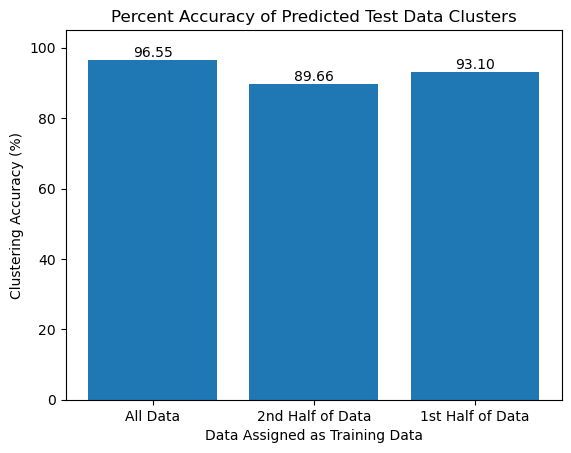

In [27]:
#Barplot of predicted clustering accuracy percentage

accuracy_list = [accuracy_all_data, accuracy_2nd_half_data, accuracy_1st_half_data]
data_label = ["All Data", "2nd Half of Data", "1st Half of Data"]

fig, ax = plt.subplots()
bar_container = ax.bar(data_label, accuracy_list)
ax.set(ylabel = 'Clustering Accuracy (%)', xlabel = 'Data Assigned as Training Data', title = 'Percent Accuracy of Predicted Test Data Clusters', ylim = (0, 105))
ax.bar_label(bar_container, fmt='{:,.2f}')

plt.show()

------------------------------------------------------------------------------------------------------------------------------

__Part 8: Additional Biological Application - Gene Expression Comparison Between Lung Cancer Types:__

By comparing the difference in average gene expression between Adenocarcinoma and Squamous Cell Carcinoma and displaying the output as an absolute value, we can identify the largest average difference between cancer types in specific genes. This allows us to identify genes that may be potential biomarkers in the onset or regulation of either lung cancer type. 

Additionally, we can determine the statistical significance of these difference by looking at each expression value's p-value by performing t-tests and Bonferroni corrections for multiple hypotheses.

In [28]:
#Organizing gene expression data based on only Adenocarcinoma cancer type and Squamous Cell Carcinoma cancer type

AD_expression_df = AD_df.merge(expression_data_all_df, how = "inner")
AD_expression_df = pd.DataFrame(AD_expression_df.mean().sort_values(ascending = False))
AD_expression_df = AD_expression_df.reset_index().rename(columns = {"index":"Gene", 0:"Expression in AD"})

SCC_expression_df = SCC_df.merge(expression_data_all_df, how = "inner")
SCC_expression_df = pd.DataFrame(SCC_expression_df.mean().sort_values(ascending = False))
SCC_expression_df = SCC_expression_df.reset_index().rename(columns = {"index":"Gene", 0:"Expression in SCC"})

#A FutureWarning will appear indicating future version changes - can ignore and continue

/var/folders/tb/vcvrpcfx3wx9c6vw189bjn3m0000gn/T/ipykernel_32841/271093703.py:4: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  AD_expression_df = pd.DataFrame(AD_expression_df.mean().sort_values(ascending = False))
/var/folders/tb/vcvrpcfx3wx9c6vw189bjn3m0000gn/T/ipykernel_32841/271093703.py:8: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  SCC_expression_df = pd.DataFrame(SCC_expression_df.mean().sort_values(ascending = False))


In [29]:
#Displays the largest expression differences between AD and SCC. This helps us to differentiate the largest disparities in
#gene expression and the specific genes that are highly expressed in each respective disease.

expression_diff_df = AD_expression_df.merge(SCC_expression_df, how = "inner")
expression_diff_df = expression_diff_df.set_index("Gene")
expression_diff_df["Expression Difference"] = abs(expression_diff_df["Expression in AD"] - expression_diff_df["Expression in SCC"])
expression_diff_df = expression_diff_df.sort_values(by = "Expression Difference", ascending = False)

print("The 10 largest differences in gene expression between Adenocarcinoma and Squamous Cell Carcinoma:")
display(expression_diff_df.head(10))

The 10 largest differences in gene expression between Adenocarcinoma and Squamous Cell Carcinoma:


,Expression in AD,Expression in SCC,Expression Difference
Gene,,,
201820_at,3.000492,10.939535,7.939043
206165_s_at,2.212801,9.058937,6.846136
232082_x_at,2.749417,9.557599,6.808183
213796_at,2.911232,9.560105,6.648873
235075_at,2.883129,9.520257,6.637128
209863_s_at,4.133841,10.527750,6.393910
217528_at,3.341643,9.645309,6.303666
206032_at,3.002822,9.140773,6.137951
206033_s_at,2.626381,8.728752,6.102371


From the dataframe above, we can see that the largest disparities in gene expression are primarily seen in genes that are more highly expressed in Squamous Cell Carcinoma opposed to Adenocarcinoma. This dataframe can help us identify potential biomarkers/genes that are associated in these specific diseases and their onset or regulation.

 For example, the gene KRT5 (which corresponds to our Gene ID 201820_at in the dataframe above) has been shown to serve as a potential biomarker for differentiating Squamous Cell Carcinoma from Adenocarcinoma (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8205719/). This aligns with the ordering of our dataframe and the expression difference between SCC and AD being the highest in KRT5 (Gene ID 201820_at).
 
In the code cells below we aimed to determine the statistical significance of these expression differences:

In [30]:
#Creating dataframe (SCC_expression_test_df) that contain only expression data for SCC and transposing it for clarity
SCC_expression_test_df = expression_data_all_df.merge(clusters_all_data, how = "inner")
SCC_expression_test_df = SCC_expression_test_df[SCC_expression_test_df.Type == "Squamous Cell Carcinoma"]
SCC_expression_test_df = SCC_expression_test_df.drop(columns = ["Type", "cluster"])
SCC_expression_test_df = SCC_expression_test_df.set_index("sample").T

#Creating dataframe (AD_expression_test_df) that contain only expression data for AD and transposing it for clarity
AD_expression_test_df = expression_data_all_df.merge(clusters_all_data, how = "inner")
AD_expression_test_df = AD_expression_test_df[AD_expression_test_df.Type == "Adenocarcinoma"]
AD_expression_test_df = AD_expression_test_df.drop(columns = ["Type", "cluster"])
AD_expression_test_df = AD_expression_test_df.set_index("sample").T

#SCC_expression_test_df
#AD_expression_test_df

In [31]:
#Creating significance_test function that calculates t-test significance (via p-value and log of p-value) iterated on each 
#sample's expression data in Adenocarcinoma vs Squamous Cell Carcinoma dataframes defined in code cells above

significance_test = pd.DataFrame(index = AD_expression_test_df.index, columns= ["statistics","p_value", "log_p"])

for i in range(0, len(AD_expression_test_df.index)):
    
    statistics, p_value = ttest_ind(AD_expression_test_df.iloc[i,:], SCC_expression_test_df.iloc[i,:])
    significance_test.iloc[i, 0] = statistics
    significance_test.iloc[i, 1] = p_value
    significance_test.iloc[i, 2] = np.log(p_value)
    
#significance_test

In [32]:
#Calculated significance at 95% confidence level and performed Bonferroni correction for multiple hypothesis tests

significance_test = significance_test.sort_values(by = "log_p", ascending = True)
significance_test.head(10)
    
#p_value threshold
a = 0.05
            
#Bonferroni correction for multiple hypotheses
b = a / 54675
                              
#filter for all rows with p less than b
significance_test_1 = significance_test.loc[significance_test["p_value"] <= b,:]

print("There are", len(significance_test_1), "statistically significant p-values (95% confidence level) in our gene expression difference dataframe:")
significance_test_1

There are 727 statistically significant p-values (95% confidence level) in our gene expression difference dataframe:


,statistics,p_value,log_p
206033_s_at,-13.076842,0.0,-41.296085
206032_at,-12.887615,0.0,-40.679935
244107_at,-12.156412,0.0,-38.25578
211194_s_at,-11.593532,0.0,-36.343033
206166_s_at,-11.58914,0.0,-36.327948
...,...,...,...
241813_at,-5.524862,0.000001,-13.933495
202854_at,-5.523782,0.000001,-13.929518
228080_at,-5.522051,0.000001,-13.923142
202972_s_at,5.521717,0.000001,-13.921915


The dataframe above helps us order the statistically significant gene expression differences in Adenocarcinoma vs Squamous Cell Carcinoma in each sample. We calculated the log_p-value in order to ensure that our p-value calculations are being ordered correctly despite the display limitation of decimal points in the p_value column. This dataframe supports our previous findings from the gene expression difference dataframe (expression_diff_df) by adding statistical signficance to each Gene ID.

The most statistically significant expression difference is found in Gene ID 206033_s_at, which correlates to the gene DSC3 and has been identified previously in literature specifically to differentiate squamous lung cancer from adenocarcinoma lung cancer (https://aacrjournals.org/cancerres/article/83/7_Supplement/881/719937/Abstract-881-Desmocollin-3-and-tumor-immune). This further supports the realistic application of our new implementation as an identifier of potential biomarkers in Adenocarcinoma and Squamous Cell Carcinoma.